# Predicting Beer Color for Heineken Brewery

### Business Understanding

- Beer brewing is not an exact process, many factors play a role in brewing high quality beer, and one of the key quality parameters is the **color**. Beer color can vary from brew to brew due to changes in the process, changes in the ingredients, and a variety of other factors that have impact on the beer color. For this reason, beer companies have master brewers who play a very important role in overseeing the process.

![Brewing Process](./assets/brewing_process.png)

### Problem 

- Currently, 7% of Heineken's beer brews do not satisfy the requirements to achieve the "perfect" range of yellow, which means that 7% of all brews needs to be remixed, taking up production capacity that could not be used for other purposes.

### Proposed Approach

- Generate a machine learning model that looks back at what happened at the past brews to predict the color of the next brew.

In [1]:
import pandas as pd
import altair as alt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pycaret.regression import *
import warnings
warnings.filterwarnings('ignore')

In [37]:
df = pd.read_csv('data/heineken_data.csv', sep=',', parse_dates=['Date/Time'])
df = df[df['Product'] == 'AMST'].drop(columns=['Unnamed: 0', 'Job ID'])
df.head()

,Date/Time,Roast amount (kg),1st malt amount (kg),2nd malt amount (kg),MT - Temperature,MT - Time,WK - Temperature,WK - Steam,WK - Time,Total cold wort,pH,Extract,Color,WOC - Time,WHP Transfer - Time,WHP Rest - Time,Roast color,1st malt color,2nd malt color,Product
0,2020-10-22 02:50:00,64.499934,16051.99658,3999.860052,67.312984,6546.750,105.408559,6482.25,6365.075,958.900,7.296127,15.309445,14.156956,3126.100,729.925,14.494583,908.375,6.1275,6.02,AMST
1,2020-10-22 05:44:00,64.500000,16067.85283,4004.256635,66.933041,6889.675,105.303989,6654.25,5929.700,963.200,7.219022,15.285057,14.270939,3135.775,733.150,14.494583,908.375,6.1275,6.02,AMST
2,2020-10-22 07:00:00,64.177513,16062.20908,3996.957605,67.177043,6614.475,105.237753,7363.75,6366.150,1088.975,7.182910,14.155171,13.269140,3492.675,912.675,14.494583,908.375,6.1275,6.02,AMST
8,2020-10-26 18:46:00,64.392526,16087.64375,4010.975385,66.901670,6708.000,105.168039,7245.50,7046.625,954.600,NaN,14.656477,18.693288,3630.275,870.750,14.494583,908.375,6.1275,6.02,AMST
9,2020-10-26 20:24:00,64.177513,16092.75000,4012.168750,67.002759,6526.325,105.133183,6686.50,6744.550,964.275,NaN,14.653028,18.176702,3136.850,740.675,14.494583,908.375,6.1275,6.02,AMST


In [38]:
df.dtypes

Date/Time               datetime64[ns]
Roast amount (kg)              float64
1st malt amount (kg)           float64
2nd malt amount (kg)           float64
MT - Temperature               float64
MT - Time                      float64
WK - Temperature               float64
WK - Steam                     float64
WK - Time                      float64
Total cold wort                float64
pH                             float64
Extract                        float64
Color                          float64
WOC - Time                     float64
WHP Transfer - Time            float64
WHP Rest - Time                float64
Roast color                    float64
1st malt color                 float64
2nd malt color                 float64
Product                         object
dtype: object

In [39]:
df.columns = [c.replace('-', '') for c in df]
df.columns = [c.replace('  ', '_') for c in df]
df.columns = [c.replace(' ', '_') for c in df]
df.columns = [c.lower() for c in df.columns]

df = df.rename(columns={'date/time':'data',
                        'roast_amount_(kg)': 'roast_amount',
                        '1st_malt_amount_(kg)': 'first_malt_amount',
                        '2nd_malt_amount_(kg)': 'second_malt_amount',
                        '1st_malt_color': 'first_malt_color',
                        '2nd_malt_color': 'second_malt_color'})
df.head()

,data,roast_amount,first_malt_amount,second_malt_amount,mt_temperature,mt_time,wk_temperature,wk_steam,wk_time,total_cold_wort,ph,extract,color,woc_time,whp_transfer_time,whp_rest_time,roast_color,first_malt_color,second_malt_color,product
0,2020-10-22 02:50:00,64.499934,16051.99658,3999.860052,67.312984,6546.750,105.408559,6482.25,6365.075,958.900,7.296127,15.309445,14.156956,3126.100,729.925,14.494583,908.375,6.1275,6.02,AMST
1,2020-10-22 05:44:00,64.500000,16067.85283,4004.256635,66.933041,6889.675,105.303989,6654.25,5929.700,963.200,7.219022,15.285057,14.270939,3135.775,733.150,14.494583,908.375,6.1275,6.02,AMST
2,2020-10-22 07:00:00,64.177513,16062.20908,3996.957605,67.177043,6614.475,105.237753,7363.75,6366.150,1088.975,7.182910,14.155171,13.269140,3492.675,912.675,14.494583,908.375,6.1275,6.02,AMST
8,2020-10-26 18:46:00,64.392526,16087.64375,4010.975385,66.901670,6708.000,105.168039,7245.50,7046.625,954.600,NaN,14.656477,18.693288,3630.275,870.750,14.494583,908.375,6.1275,6.02,AMST
9,2020-10-26 20:24:00,64.177513,16092.75000,4012.168750,67.002759,6526.325,105.133183,6686.50,6744.550,964.275,NaN,14.653028,18.176702,3136.850,740.675,14.494583,908.375,6.1275,6.02,AMST


In [40]:
df.data = pd.to_datetime(df.data, format="%d/%m/%Y")

In [41]:
df.shape

(180, 20)

In [42]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
roast_amount,177.0,39.24,18.03,17.42,24.51,27.95,54.82,88.04
first_malt_amount,180.0,13605.00,1305.27,0.00,12593.28,14024.92,14083.29,16092.75
second_malt_amount,180.0,6692.74,1174.83,3996.96,6069.17,6075.34,8326.37,8462.08
mt_temperature,180.0,67.80,2.81,66.87,66.93,67.00,67.18,81.45
mt_time,180.0,6741.18,407.52,6458.60,6614.48,6684.89,6767.39,11671.28
wk_temperature,180.0,105.25,0.58,97.66,105.20,105.27,105.37,105.72
wk_steam,180.0,6707.52,266.94,6170.50,6557.50,6654.25,6804.75,8202.25
wk_time,180.0,6759.12,544.10,5929.70,6552.66,6661.78,6791.58,12621.58
total_cold_wort,180.0,942.52,123.51,68.80,956.75,963.20,972.07,1088.97
ph,175.0,5.57,0.62,2.30,5.55,5.62,5.71,7.38


In [43]:
#distributions
alt.Chart(df.drop(columns=['data', 'product']).melt()).mark_boxplot().encode(
    x='variable',
    y='value'
).interactive()

alt.Chart(...)

- roast_color é uma constante, a variância não explica nada
- target é a variável com maior quantidade de missings
- alguns outliers

In [44]:
#outliers
for column in df.columns[1:-1]:
    lower = df[column].quantile(.05)
    upper = df[column].quantile(.95)
    df[column] = df[column].clip(lower=lower, upper=upper)
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
roast_amount,177.0,39.14,17.71,20.53,24.51,27.95,54.82,64.52
first_malt_amount,180.0,13611.73,683.56,12519.62,12593.28,14024.92,14083.29,14142.87
second_malt_amount,180.0,6760.31,1069.45,5907.93,6069.17,6075.34,8326.37,8430.54
mt_temperature,180.0,67.74,2.57,66.87,66.93,67.00,67.18,77.27
mt_time,180.0,6707.23,135.88,6530.62,6614.48,6684.89,6767.39,7093.60
wk_temperature,180.0,105.29,0.11,105.13,105.20,105.27,105.37,105.51
wk_steam,180.0,6698.33,210.22,6395.17,6557.50,6654.25,6804.75,7245.50
wk_time,180.0,6713.36,222.63,6429.36,6552.66,6661.78,6791.58,7307.63
total_cold_wort,180.0,963.32,10.22,941.59,956.75,963.20,972.07,979.32
ph,175.0,5.60,0.20,5.09,5.55,5.62,5.71,5.97


In [45]:
# check for null values
missing_values = pd.DataFrame(df.isnull().sum()*100/len(df), 
                              columns=['percentage_of_missing_values']).round(2)

alt.Chart(missing_values.reset_index()).mark_bar().encode(
    x='index',
    y = alt.Y('percentage_of_missing_values', scale=alt.Scale(domain=[0, 100]))
).interactive()

alt.Chart(...)

In [46]:
#correlation matrix
corrMatrix = df.corr().reset_index().melt('index')
corrMatrix.columns = ['var1', 'var2', 'correlation']
corrMatrix['correlation_label']= corrMatrix['correlation'].map('{:.2f}'.format)
corrMatrix
base = alt.Chart(corrMatrix).encode(
    x='var2:O',
    y='var1:O'
)
#text layer w/ correlation labels
text = base.mark_text().encode(
    text = 'correlation_label',
    color=alt.condition(
    alt.datum.correlation>0.5,
    alt.value('white'),
    alt.value('black')
    )
)

#the correlation heatmap itself
cor_plot = base.mark_rect().encode(
    color = 'correlation:Q'
).properties(
    width=600,
    height=600
)

cor_plot + text

alt.LayerChart(...)

In [47]:
features_set = df.drop(columns=['data', 'roast_color'])
features_set

,roast_amount,first_malt_amount,second_malt_amount,mt_temperature,mt_time,wk_temperature,wk_steam,wk_time,total_cold_wort,ph,extract,color,woc_time,whp_transfer_time,whp_rest_time,first_malt_color,second_malt_color,product
0,64.499934,14142.869333,5907.931250,67.312984,6546.7500,105.408559,6482.25,6429.360,958.9000,5.971395,15.309445,14.156956,3126.10000,729.92500,14.494583,6.1275,6.02,AMST
1,64.500000,14142.869333,5907.931250,66.933041,6889.6750,105.303989,6654.25,6429.360,963.2000,5.971395,15.285057,14.270939,3135.77500,733.15000,14.494583,6.1275,6.02,AMST
2,64.177513,14142.869333,5907.931250,67.177043,6614.4750,105.237753,7245.50,6429.360,979.3250,5.971395,14.656305,13.269140,3492.67500,861.12875,14.494583,6.1275,6.02,AMST
8,64.392526,14142.869333,5907.931250,66.901670,6708.0000,105.168039,7245.50,7046.625,954.6000,NaN,14.656477,18.693288,3630.27500,861.12875,14.494583,6.1275,6.02,AMST
9,64.177513,14142.869333,5907.931250,67.002759,6530.6250,105.133183,6686.50,6744.550,964.2750,NaN,14.656305,18.176702,3136.85000,740.67500,14.494583,6.1275,6.02,AMST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,21.284987,12565.234080,8388.171460,67.243271,6835.9250,105.133183,6654.25,7307.635,941.5925,5.675958,15.391623,12.937645,3078.53125,742.82500,14.494583,6.1275,6.02,AMST
196,20.532592,12519.616079,8389.450647,77.233385,7093.6025,105.133183,6815.50,6798.300,941.5925,5.642286,14.656305,13.444820,3078.53125,761.10000,14.494583,6.1275,6.02,AMST
197,20.532592,12640.065210,8387.569397,66.967902,7093.6025,105.202896,6697.25,6869.250,941.5925,5.632526,14.656305,13.181298,3078.53125,741.75000,14.494583,6.1275,6.02,AMST
198,53.534987,12567.449170,8294.538855,67.002759,6711.2250,105.168039,6450.00,6815.500,975.0250,5.801374,15.807836,14.270939,3078.53125,741.75000,14.494583,6.1275,6.02,AMST


In [48]:
pd.DataFrame(df.var(), columns=['variance']).round(2)

,variance
roast_amount,313.47
first_malt_amount,467254.49
second_malt_amount,1143725.25
mt_temperature,6.62
mt_time,18462.02
wk_temperature,0.01
wk_steam,44193.73
wk_time,49562.94
total_cold_wort,104.44
ph,0.04


In [49]:
# VIF dataframe
features_set = df.drop(columns=['data', 'roast_color', 'product']).fillna(0)
vif_data = pd.DataFrame()
vif_data['feature'] = features_set.columns

#calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(features_set.values, i)
                   for i in range(len(features_set.columns))]
display(vif_data)

,feature,VIF
0,roast_amount,1.293071
1,first_malt_amount,116.570249
2,second_malt_amount,116.514990
3,mt_temperature,1.074992
4,mt_time,1.160658
5,wk_temperature,1.618981
6,wk_steam,1.610879
7,wk_time,1.481265
8,total_cold_wort,1.777454
9,ph,1.098922


In [50]:
alt.Chart(df).mark_line().encode(
    x='data:T',
    y='color:Q'
).interactive()

alt.Chart(...)

In [51]:
def normalize(feature):
    return (feature - feature.mean())/feature.std()

# Setup

In [59]:
selected_df = df.drop(columns=['data', 'roast_color', 'product']).round(2)

In [60]:
selected_df['ph'].fillna(selected_df['ph'].mean(), inplace=True)

In [61]:
selected_df.isna().sum()

roast_amount           3
first_malt_amount      0
second_malt_amount     0
mt_temperature         0
mt_time                0
wk_temperature         0
wk_steam               0
wk_time                0
total_cold_wort        0
ph                     0
extract                0
color                 30
woc_time               0
whp_transfer_time      0
whp_rest_time          0
first_malt_color       0
second_malt_color      0
dtype: int64

In [62]:
cols_to_norm = ['roast_amount', 'first_malt_amount', 'second_malt_amount',
       'mt_temperature', 'mt_time', 'wk_temperature', 'wk_steam', 'wk_time',
       'total_cold_wort', 'ph', 'extract', 'woc_time',
       'whp_transfer_time', 'whp_rest_time', 'first_malt_color',
       'second_malt_color']
selected_df[cols_to_norm] = selected_df[cols_to_norm].apply(normalize)

In [63]:
selected_df['color']

0      14.16
1      14.27
2      13.27
8      18.69
9      18.18
       ...  
195    12.94
196    13.44
197    13.18
198    14.27
199    12.96
Name: color, Length: 180, dtype: float64

# Preprocessing

In [64]:
s = setup(selected_df.dropna(), target = 'color', 
          session_id = 123,
          numeric_features=['roast_amount', 'first_malt_amount', 'second_malt_amount',
                           'mt_temperature', 'mt_time', 'wk_temperature', 'wk_steam', 'wk_time',
                           'total_cold_wort', 'ph', 'extract', 'woc_time',
                           'whp_transfer_time', 'whp_rest_time', 'first_malt_color',
                           'second_malt_color'],
          transformation = True, transformation_method = 'quantile',
          silent=True
         )

,Description,Value
0,session_id,123
1,Target,color
2,Original Data,"(147, 17)"
3,Missing Values,False
4,Numeric Features,16
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(102, 16)"


In [65]:
get_config('X')

,roast_amount,first_malt_amount,second_malt_amount,mt_temperature,mt_time,wk_temperature,wk_steam,wk_time,total_cold_wort,ph,extract,woc_time,whp_transfer_time,whp_rest_time,first_malt_color,second_malt_color
0,1.444797,5.199337,-5.199337,1.206246,-1.838379,0.831058,-1.206246,-5.199337,-0.187224,5.199337,-0.302362,-0.448953,-0.620918,-5.199337,5.199337,-5.199337
1,1.444797,5.199337,-5.199337,-0.682300,1.287214,0.328446,-0.012409,-5.199337,0.174610,5.199337,-0.421668,-0.238000,-0.341572,-5.199337,5.199337,-5.199337
2,0.698046,5.199337,-5.199337,0.576383,-0.848716,-0.276482,1.755301,-5.199337,5.199337,5.199337,-1.964217,1.559780,1.964216,-5.199337,5.199337,-5.199337
8,1.180947,5.199337,-5.199337,-1.042824,0.111915,-1.042824,1.755301,1.042824,-0.591097,-0.062085,-1.964217,1.649673,1.964216,-5.199337,5.199337,-5.199337
9,0.698046,5.199337,-5.199337,-0.012409,-5.199337,-5.199337,0.212543,0.245306,0.381314,-0.062085,-1.964217,-0.199868,0.302362,-5.199337,5.199337,-5.199337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-1.790340,-1.949508,1.486105,0.848716,1.188098,-5.199337,-0.012409,1.885177,-2.057856,0.448953,0.074523,-5.199337,0.490525,-5.199337,5.199337,-5.199337
196,-5.199337,-5.199337,1.497187,1.754545,2.174028,-5.199337,0.698046,0.514850,-2.057856,0.238000,-1.964217,-5.199337,0.994166,-5.199337,5.199337,-5.199337
197,-5.199337,-0.960838,1.480973,-0.328446,2.174028,-0.605940,0.276482,0.848716,-2.057856,0.124411,-1.964217,-5.199337,0.394693,-5.199337,5.199337,-5.199337
198,0.315377,-1.885177,1.042824,-0.012409,0.174610,-1.042824,-1.377632,0.605940,1.156382,1.021684,5.199337,-5.199337,0.394693,-5.199337,5.199337,-5.199337


In [66]:
get_config('X').isnull().sum()

roast_amount          0
first_malt_amount     0
second_malt_amount    0
mt_temperature        0
mt_time               0
wk_temperature        0
wk_steam              0
wk_time               0
total_cold_wort       0
ph                    0
extract               0
woc_time              0
whp_transfer_time     0
whp_rest_time         0
first_malt_color      0
second_malt_color     0
dtype: int64

# Model Training

In [67]:
best = compare_models(include = ['lr', 'dt', 'lightgbm', 'gbr', 'ada'], sort=('R2'))

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,5.2807,81.2820,7.9589,-8.0961,0.3253,0.2563,0.0190
gbr,Gradient Boosting Regressor,6.3783,86.9491,8.5345,-8.5760,0.3617,0.3298,0.0120
lightgbm,Light Gradient Boosting Machine,6.7107,74.0407,8.2587,-9.4769,0.3767,0.3661,0.0150
lr,Linear Regression,8.1089,107.8652,10.0313,-17.1355,0.4678,0.4542,0.6340
dt,Decision Tree Regressor,6.6981,152.9376,10.6070,-35.8143,0.4300,0.3508,0.0070


In [68]:
ada = create_model('ada')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.5914,26.0251,5.1015,0.1330,0.2449,0.2149
1,5.9792,82.5340,9.0848,0.1768,0.3590,0.3470
2,2.4839,9.5495,3.0902,0.6869,0.1663,0.1605
3,3.2542,29.7916,5.4582,0.7158,0.2459,0.1574
4,6.2257,119.4501,10.9293,0.2562,0.4168,0.2345
5,6.3881,112.0343,10.5846,-0.0664,0.3928,0.3694
6,12.9660,315.2459,17.7552,-0.6910,0.6485,0.3684
7,2.4228,8.5293,2.9205,0.7323,0.1557,0.1597
8,3.8183,39.6865,6.2997,-83.4989,0.3147,0.2885


In [69]:
print(ada)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=123)


In [70]:
ada = tune_model(ada, fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.2837,35.5865,5.9654,0.4858,0.2883,0.2772
1,2.9908,17.1412,4.1402,0.7498,0.2156,0.1898
2,5.4304,80.9180,8.9954,0.4018,0.3313,0.2178
3,6.5065,129.4934,11.3795,0.1121,0.4067,0.2250
4,5.2460,71.8248,8.4750,0.2990,0.3533,0.2916
Mean,4.8915,66.9928,7.7911,0.4097,0.3191,0.2403
Std,1.1838,38.9747,2.5083,0.2109,0.0643,0.0382


In [71]:
evaluate_model(ada)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

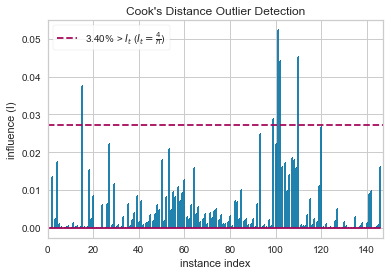

In [30]:
# Cooks Distance Plot
plot_model(ada, plot='cooks')

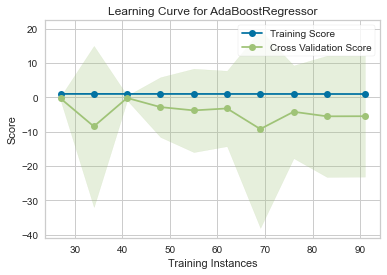

In [31]:
# Learning Curve
plot_model(ada, plot='learning')

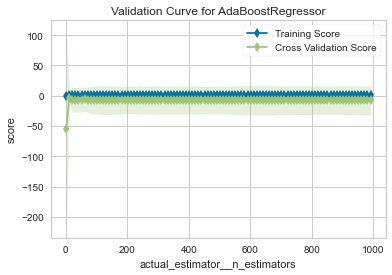

In [32]:
# Validation Curve
plot_model(ada, plot='vc')

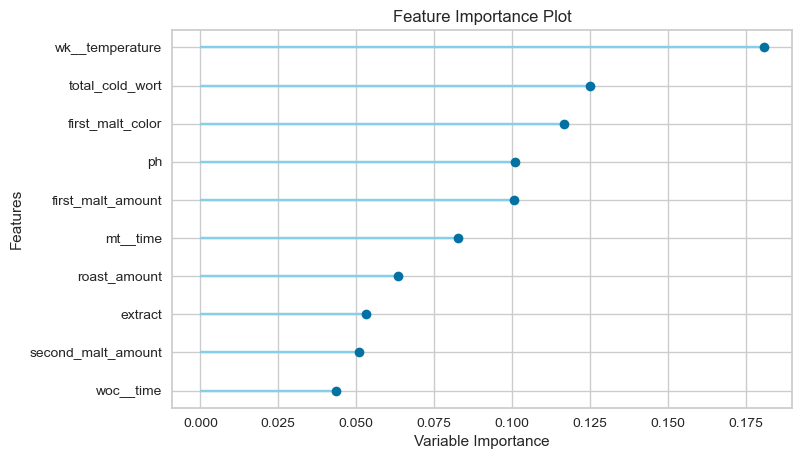

In [33]:
# Plot of Feature Importance
plot_model(ada, plot='feature')

In [72]:
# predict on test set
holdout_pred = predict_model(ada)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,2.7942,20.1855,4.4928,0.6685,0.1830,0.1548


In [73]:
# show predictions df
holdout_pred.loc[:,['color', 'Label']].head()

,color,Label
0,12.12,15.098478
1,13.57,14.138750
2,13.16,14.021667
3,13.62,13.742076
4,13.24,15.645000


# Finish to put into production

In [74]:
# finalize the model
final_best = finalize_model(ada)

# save model to disk
save_model(final_best, 'beer-color-pipeline2')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['roast_amount',
                                                           'first_malt_amount',
                                                           'second_malt_amount',
                                                           'mt_temperature',
                                                           'mt_time',
                                                           'wk_temperature',
                                                           'wk_steam', 'wk_time',
                                                           'total_cold_wort',
                                                           'ph', 'extract',
                              

/Users/aline/anaconda3/envs/di2win/lib/python3.8/site-packages/sklearn/tree/_classes.py:1254: FutureWarning: the classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
  warnings.warn(msg, FutureWarning)
/Users/aline/anaconda3/envs/di2win/lib/python3.8/site-packages/sklearn/tree/_classes.py:1262: FutureWarning: the n_classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
  warnings.warn(msg, FutureWarning)
/Users/aline/anaconda3/envs/di2win/lib/python3.8/site-packages/sklearn/tree/_classes.py:1254: FutureWarning: the classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
  warnings.warn(msg, FutureWarning)
/Users/aline/anaconda3/envs/di2win/lib/python3.8/site-packages/sklearn/tree/_classes.py:1262: FutureWarning: the n_classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
  warnings.warn(msg, FutureWarning)
/Users/aline/anaconda3/envs/di2win/lib/python3.8/site-pa

In [75]:
saved_final = load_model('beer-color-pipeline2')

Transformation Pipeline and Model Successfully Loaded


In [76]:
get_config('X').head()

,roast_amount,first_malt_amount,second_malt_amount,mt_temperature,mt_time,wk_temperature,wk_steam,wk_time,total_cold_wort,ph,extract,woc_time,whp_transfer_time,whp_rest_time,first_malt_color,second_malt_color
0,1.444797,5.199337,-5.199337,1.206246,-1.838379,0.831058,-1.206246,-5.199337,-0.187224,5.199337,-0.302362,-0.448953,-0.620918,-5.199337,5.199337,-5.199337
1,1.444797,5.199337,-5.199337,-0.682300,1.287214,0.328446,-0.012409,-5.199337,0.174610,5.199337,-0.421668,-0.238000,-0.341572,-5.199337,5.199337,-5.199337
2,0.698046,5.199337,-5.199337,0.576383,-0.848716,-0.276482,1.755301,-5.199337,5.199337,5.199337,-1.964217,1.559780,1.964216,-5.199337,5.199337,-5.199337
8,1.180947,5.199337,-5.199337,-1.042824,0.111915,-1.042824,1.755301,1.042824,-0.591097,-0.062085,-1.964217,1.649673,1.964216,-5.199337,5.199337,-5.199337
9,0.698046,5.199337,-5.199337,-0.012409,-5.199337,-5.199337,0.212543,0.245306,0.381314,-0.062085,-1.964217,-0.199868,0.302362,-5.199337,5.199337,-5.199337
